# GradCAM
#### G27 
Dave Brunner

In [603]:
import PIL
import numpy as np
import torch
import torchvision
from matplotlib import cm, pyplot as plt
from torch.nn import Sequential, Flatten, Linear, ReLU, Module, Conv2d, MaxPool2d, CrossEntropyLoss
from torch.nn.functional import interpolate
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from torchvision import datasets

In [604]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [605]:
training_data = datasets.FashionMNIST(root="data", train=True, download=True,
                                      transform=torchvision.transforms.ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=torchvision.transforms.ToTensor())

print(f'Training data: {len(training_data)}')
print(f'Test data: {len(test_data)}')
print(f'Test data shape: {test_data.data.shape}')

Training data: 60000
Test data: 10000
Test data shape: torch.Size([10000, 28, 28])


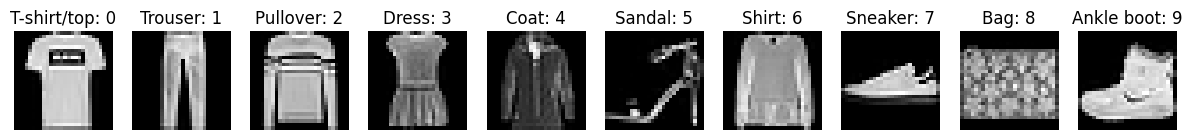

In [606]:
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(training_data.data[training_data.targets == i][0], cmap='gray')
    axs[i].set_title(training_data.classes[i] + f': {i}')
    axs[i].axis('off')

In [607]:
# move data to device
# training_data.data = training_data.data.to(device)
# training_data.targets = training_data.targets.to(device)
# test_data.data = test_data.data.to(device)
# test_data.targets = test_data.targets.to(device)

In [608]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the sequential model
        self.model = Sequential(
            Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            ReLU(),  # Activation
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            ReLU(),  # Activation
            MaxPool2d(kernel_size=2, stride=2),
            Flatten(),  # Flatten for fully connected layer
            Linear(in_features=16 * 7 * 7, out_features=128),
            ReLU(),  # Activation
            Linear(in_features=128, out_features=10)  # Output layer
        )

    def forward(self, x):
        # Pass the input through the sequential model
        x = self.model(x)
        return x


# Create an instance of the model
model = CNN()
print(model)
summary(model, (1, 28, 28))
model.to(device)

CNN(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=784, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,320
              ReLU-5           [-1, 16, 14, 14]    

CNN(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=784, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [609]:
model = CNN().to(device)

n_epochs = 10
n_batch = 1024
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loader = DataLoader(training_data, batch_size=n_batch, shuffle=True)
train_loader_all = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

print('Moving data to device...')
train_loader = [(data.to(device), target.to(device)) for data, target in train_loader]
train_loader_all = [(data.to(device), target.to(device)) for data, target in train_loader_all]
test_loader = [(data.to(device), target.to(device)) for data, target in test_loader]
print(f'Data moved to device {device}')

train_acc, val_acc = [], []
train_loss, val_loss = [], []

for epoch in range(n_epochs):
    # enumerate mini batches
    print(f'Epoch: {epoch + 1}')
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        optimizer.zero_grad()
        yhat = model(train_x)
        loss = loss_fn(yhat, train_y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for train_x, train_y in train_loader_all:
            yhat = model(train_x)
            train_loss.append(loss_fn(yhat, train_y).item())
            train_acc.append(((yhat.argmax(1) == train_y).float().mean()).to('cpu'))
            print(f'Training   -> Loss: {train_loss[-1]:.3f}, Accuracy: {train_acc[-1]:.3f}')
        for test_x, test_y in test_loader:
            yhat = model(test_x)
            val_loss.append(loss_fn(yhat, test_y).item())
            val_acc.append(((yhat.argmax(1) == test_y).float().mean()).to('cpu'))
            print(f'Validation -> Loss: {val_loss[-1]:.3f}, Accuracy: {val_acc[-1]:.3f}')
    print('------------------------------------------------')

Moving data to device...
Data moved to device mps
Epoch: 1
Training   -> Loss: 0.421, Accuracy: 0.846
Validation -> Loss: 0.449, Accuracy: 0.832
------------------------------------------------
Epoch: 2
Training   -> Loss: 0.332, Accuracy: 0.879
Validation -> Loss: 0.367, Accuracy: 0.867
------------------------------------------------
Epoch: 3
Training   -> Loss: 0.295, Accuracy: 0.891
Validation -> Loss: 0.331, Accuracy: 0.880
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.257, Accuracy: 0.904
Validation -> Loss: 0.300, Accuracy: 0.890
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.242, Accuracy: 0.911
Validation -> Loss: 0.291, Accuracy: 0.894
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.236, Accuracy: 0.914
Validation -> Loss: 0.288, Accuracy: 0.896
------------------------------------------------
Epoch: 7
Training   -> Loss: 0.223, Accuracy: 0.918
Validation -> Loss: 0.282, Accurac

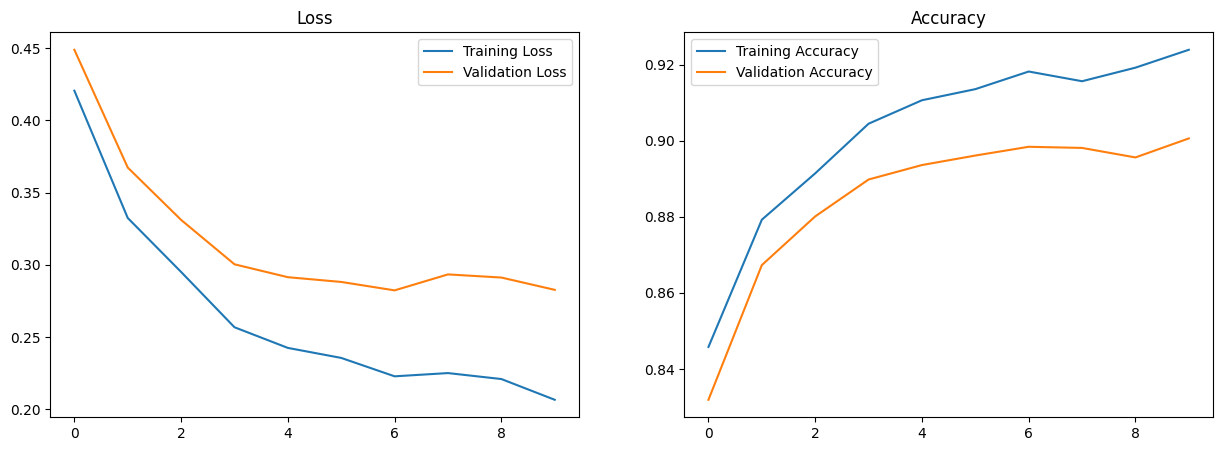

In [610]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [611]:
def hook_store_A(module, input, output):
    module.A = output[0]


def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]

In [612]:
relu_layer = model.model[4]
print(relu_layer)
relu_layer.register_forward_hook(hook_store_A)
relu_layer.register_backward_hook(hook_store_dydA)

ReLU()


In [654]:
to_tensor = torchvision.transforms.ToTensor()


def plot_grad_cam(model, img, c, layer):
    if isinstance(img, torch.Tensor):
        input = img
        
    else:
        img = img.resize((28, 28))
        input = to_tensor(img)
    input = torch.mean(input, 0, keepdim=True)
    input = input.unsqueeze(0).to(device)
    print(f'Input shape: {input.shape}')
    print(input)
    output = model(input)
    print(f'Prediction: {output.argmax(1).item()} {training_data.classes[output.argmax(1).item()]}')

    output[0, c].backward()
    alpha = layer.dydA.mean((0, 1), keepdim=True)
    L = torch.relu((alpha * layer.A).sum(1, keepdim=True))
    L = L.to('cpu')
    L = L / L.max()
    L = interpolate(L, size=(input.size(2), input.size(3)),
                    mode='bilinear', align_corners=False)
    l = L.view(L.size(2), L.size(3)).detach().numpy()

    PIL.Image.fromarray(np.uint8(cm.gist_earth(l) * 255)).save('result.png')

    plt.figure(1, figsize=(15, 15))
    plt.subplot2grid((1, 2), (0, 0))
    plt.imshow(PIL.Image.open('dress.png'))
    plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(PIL.Image.open('result.png'))
    plt.show()

Input shape: torch.Size([1, 1, 28, 28])
tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 0.9961, 0.9490, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           0.9961, 0.9569, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 0.9856, 0.8392, 0.9399, 1.0000, 1.0000, 1.0000, 1.0000,
           0.9242, 0.8654, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 0.9922, 0.9268, 0.9451, 0.9529, 1.0000, 1.0000, 0.9529,
   

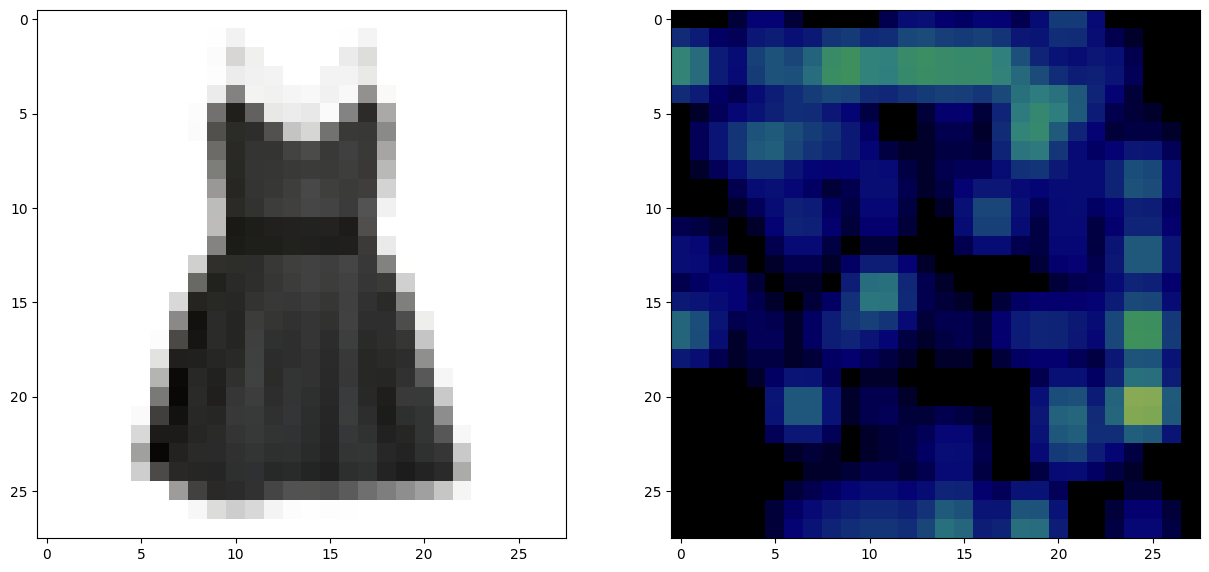

In [655]:
img = PIL.Image.open('dress.png')
plot_grad_cam(model, img, 3, relu_layer)

In [649]:
for i in range(10):
    img = training_data.data[training_data.targets == i][0]
    # convert to float
    img = img.to(torch.float32)
    plot_grad_cam(model, img, i, relu_layer)

Image shape: torch.Size([28, 28])
Image shape: torch.Size([28, 28])
Input shape: torch.Size([28, 28])
tensor([[  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,  41., 188.,
         103.,  54.,  48.,  43.,  87., 168., 133.,  16.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0.,   0.,   0.,  49., 136., 219., 216., 228.,
         236., 255., 255., 255., 255., 217., 215., 254., 231., 160.,  45.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  14., 176., 222., 224., 212., 203., 198.,
         196., 200., 215., 204., 202., 201., 201., 201., 209., 218., 224., 164.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 188., 219., 200., 198., 202., 198., 199.,
         199., 201., 196., 198., 198., 200., 200., 200., 200., 201., 200., 225.,
          41.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  51., 219., 199., 203., 203., 212., 238., 248.,
         250., 245., 249., 246., 

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [28, 28]